You can find section 3 here: http://localhost:8891/notebooks/Documents/GitHub/Problem-Set-2-Legal-Studies-123/Docs/Machine%20Learning%20and%20Crime%20(SECTION%203).ipynb

# Problem Set 2 --- SFPD Machine Learning and Crime

In [25]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 2 Get the Data

The data has been significantly cleaned. It matches neighborhood descriptions from the “Analysis Neighborhoods” dataset available on SFOpenData to the U.S. Census tract-level information about the socioeconomic and demographic characteristics of the neighborhoods from 2011-2016. If you’re feeling ambitious, you can look at the raw data and see if there are any improvements that you can make!

The objective of this problem set will be to develop an algorithm that predicts how many crimes
a neighborhood will experience per month, and to understand its accuracy and fairness on a new dataset. Throughout the problem set, be sure to relabel your features so that they are more easily
interpreted, and give reasons for your analytic choices.

2.1) Is this a supervised or an unsupervised learning problem? Explain.

This is almost certainly a supervised learning problem. The key factor here lies in that the data is heavily cleaned - unsupervised learning usually occurs with data that is unstructured and/or unlabeled, and where researchers are looking for the structures or patterns in the data. The goal of the project also indicates that it's a supervised learning problem: supervised learning is meant to predict how new data should look, whereas unsupervised is more focused just on figuring out patterns in the data as is. 

2.2) Clean and manipulate the data so that you have information about the amount of crime per SF neighborhood per month from 2003-2017.

In [26]:
# df = pd.read_csv('San Francisco Crime by Neighborhood and Tract.csv')
# df = pd.read_csv('C:\\Users\\timet\\Desktop\\GitHub\\Problem-Set-2-Legal-Studies-123\Data\San Francisco Crime by Neighborhood and Tract.csv')
df = pd.read_csv('C:\\Users\\kharr\\Documents\\GitHub\\Problem-Set-2-Legal-Studies-123\Data\San Francisco Crime by Neighborhood and Tract.csv')

df_q1 = df
df.head(5)
print('df has',df.index.size,'rows')

,neighborhood,Month_Year,number_crimes,tractce10,VC03,VC04,VC05,VC06,VC07,VC08,...,VC206,VC207,VC208,VC209,VC210,VC211,VC212,VC216,VC217,VC218
0,North Beach,01/2003,168,10100,2059,815,178,545,140,17,...,0,0,22,0,0,0,14,NaN,NaN,NaN
1,North Beach,01/2004,162,10100,2059,815,178,545,140,17,...,0,0,22,0,0,0,14,NaN,NaN,NaN
2,North Beach,01/2005,174,10100,2059,815,178,545,140,17,...,0,0,22,0,0,0,14,NaN,NaN,NaN
3,North Beach,01/2006,185,10100,2059,815,178,545,140,17,...,0,0,22,0,0,0,14,NaN,NaN,NaN
4,North Beach,01/2007,153,10100,2059,815,178,545,140,17,...,0,0,22,0,0,0,14,NaN,NaN,NaN


df has 35295 rows


In [27]:
df = df.drop_duplicates()
df = df.fillna(0)
df.index.size

df_q1 = df_q1.drop_duplicates()
df_q1 = df_q1.fillna(0)
df_q1.index.size

35295

35295

In [28]:
#https://www.geeksforgeeks.org/how-to-drop-one-or-multiple-columns-in-pandas-dataframe/
df_q1.drop(df_q1.iloc[:, 3:], inplace = True, axis = 1)
df_q1.head()

,neighborhood,Month_Year,number_crimes
0,North Beach,01/2003,168
1,North Beach,01/2004,162
2,North Beach,01/2005,174
3,North Beach,01/2006,185
4,North Beach,01/2007,153


In [29]:
# small_copy = small_copy.groupby(['Month_Year'])
# small_copy.head()

df_q1 = df_q1.sort_values(['Month_Year'], ascending=True)
df_q1 = df_q1.reset_index()
df_q1 = df_q1.iloc[: , 1:]

In [30]:
df_q1.head(41)

,neighborhood,Month_Year,number_crimes
0,North Beach,01/2003,168
1,Outer Mission,01/2003,75
2,Outer Richmond,01/2003,1806
3,Tenderloin,01/2003,951
4,Castro/Upper Market,01/2003,291
5,Excelsior,01/2003,390
6,Tenderloin,01/2003,951
7,Castro/Upper Market,01/2003,291
8,Mission,01/2003,635
9,Bayview Hunters Point,01/2003,573


2.3.1) Partition the data into a training set, a validation set, and a test set.

In [31]:
df.head(5)
# print(df.columns.to_list())

,neighborhood,Month_Year,number_crimes,tractce10,VC03,VC04,VC05,VC06,VC07,VC08,...,VC206,VC207,VC208,VC209,VC210,VC211,VC212,VC216,VC217,VC218
0,North Beach,01/2003,168,10100,2059,815,178,545,140,17,...,0,0,22,0,0,0,14,0.0,0.0,0.0
1,North Beach,01/2004,162,10100,2059,815,178,545,140,17,...,0,0,22,0,0,0,14,0.0,0.0,0.0
2,North Beach,01/2005,174,10100,2059,815,178,545,140,17,...,0,0,22,0,0,0,14,0.0,0.0,0.0
3,North Beach,01/2006,185,10100,2059,815,178,545,140,17,...,0,0,22,0,0,0,14,0.0,0.0,0.0
4,North Beach,01/2007,153,10100,2059,815,178,545,140,17,...,0,0,22,0,0,0,14,0.0,0.0,0.0


In [32]:
df["Month_Year"] = pd.to_datetime(df["Month_Year"])

In [33]:
df['yyyy'] = pd.to_datetime(df['Month_Year']).dt.year
df['mm'] = pd.to_datetime(df['Month_Year']).dt.month

move_1 = df.pop("yyyy")
df.insert(2, "yyyy", move_1 )

move_2 = df.pop("mm")
df.insert(3, "mm", move_2 )

df.head()

,neighborhood,Month_Year,yyyy,mm,number_crimes,tractce10,VC03,VC04,VC05,VC06,...,VC206,VC207,VC208,VC209,VC210,VC211,VC212,VC216,VC217,VC218
0,North Beach,2003-01-01,2003,1,168,10100,2059,815,178,545,...,0,0,22,0,0,0,14,0.0,0.0,0.0
1,North Beach,2004-01-01,2004,1,162,10100,2059,815,178,545,...,0,0,22,0,0,0,14,0.0,0.0,0.0
2,North Beach,2005-01-01,2005,1,174,10100,2059,815,178,545,...,0,0,22,0,0,0,14,0.0,0.0,0.0
3,North Beach,2006-01-01,2006,1,185,10100,2059,815,178,545,...,0,0,22,0,0,0,14,0.0,0.0,0.0
4,North Beach,2007-01-01,2007,1,153,10100,2059,815,178,545,...,0,0,22,0,0,0,14,0.0,0.0,0.0


In [34]:
df['neighborhood'].unique()

array(['North Beach', 'Russian Hill', 'Financial District/South Beach',
       'Chinatown', 'Nob Hill', 'Tenderloin', 'Marina', 'Pacific Heights',
       'Presidio Heights', 'Western Addition', 'Japantown',
       'Lone Mountain/USF', 'Hayes Valley', 'Haight Ashbury',
       'Castro/Upper Market', 'South of Market', 'Mission',
       'Treasure Island', 'Twin Peaks', 'Noe Valley', 'Glen Park',
       'Potrero Hill', 'Bayview Hunters Point', 'Bernal Heights',
       'Outer Mission', 'Excelsior', 'Portola', 'Visitacion Valley',
       'Inner Sunset', 'West of Twin Peaks', 'Oceanview/Merced/Ingleside',
       'Sunset/Parkside', 'Lakeshore', 'Inner Richmond', 'Outer Richmond',
       'Seacliff', 'Presidio', 'Mission Bay', 'Lincoln Park',
       'Golden Gate Park', 'McLaren Park'], dtype=object)

In [35]:
df['neighborhood'] = pd.factorize(df.neighborhood)[0] + 1
X = df

X = X.drop(['number_crimes'], axis=1)
X = X.drop(['Month_Year'], axis=1) #now that we have month and year as their own columns, this is okay. 
X.head()

y = df['number_crimes']

,neighborhood,yyyy,mm,tractce10,VC03,VC04,VC05,VC06,VC07,VC08,...,VC206,VC207,VC208,VC209,VC210,VC211,VC212,VC216,VC217,VC218
0,1,2003,1,10100,2059,815,178,545,140,17,...,0,0,22,0,0,0,14,0.0,0.0,0.0
1,1,2004,1,10100,2059,815,178,545,140,17,...,0,0,22,0,0,0,14,0.0,0.0,0.0
2,1,2005,1,10100,2059,815,178,545,140,17,...,0,0,22,0,0,0,14,0.0,0.0,0.0
3,1,2006,1,10100,2059,815,178,545,140,17,...,0,0,22,0,0,0,14,0.0,0.0,0.0
4,1,2007,1,10100,2059,815,178,545,140,17,...,0,0,22,0,0,0,14,0.0,0.0,0.0


In [36]:
# # https://towardsdatascience.com/data-cleaning-series-with-python-part-1-24bb603c82c8#:~:text=the%20number%200.-,Central%20Value%20Imputation,-Central%20value%20imputation
# from sklearn.impute import SimpleImputer

# num_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# vals = X.values

# # Fit imputer to data to retrieve central measure:
# num_imputer.fit(vals)

# # Transforming missing data points to mean value:
# num_imputer.transform(vals)

In [37]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)
X.head()

y = df['number_crimes']

,neighborhood,yyyy,mm,tractce10,VC03,VC04,VC05,VC06,VC07,VC08,...,VC206,VC207,VC208,VC209,VC210,VC211,VC212,VC216,VC217,VC218
0,-1.790999,-1.619670,-1.577822,-0.26049,0.284194,-0.082777,-0.718781,-0.270253,-0.636843,-0.915586,...,-0.424159,-0.51859,-0.583695,-0.651127,-0.643267,-0.838539,0.157638,0.0,0.0,0.0
1,-1.790999,-1.389740,-1.577822,-0.26049,0.284194,-0.082777,-0.718781,-0.270253,-0.636843,-0.915586,...,-0.424159,-0.51859,-0.583695,-0.651127,-0.643267,-0.838539,0.157638,0.0,0.0,0.0
2,-1.790999,-1.159811,-1.577822,-0.26049,0.284194,-0.082777,-0.718781,-0.270253,-0.636843,-0.915586,...,-0.424159,-0.51859,-0.583695,-0.651127,-0.643267,-0.838539,0.157638,0.0,0.0,0.0
3,-1.790999,-0.929881,-1.577822,-0.26049,0.284194,-0.082777,-0.718781,-0.270253,-0.636843,-0.915586,...,-0.424159,-0.51859,-0.583695,-0.651127,-0.643267,-0.838539,0.157638,0.0,0.0,0.0
4,-1.790999,-0.699951,-1.577822,-0.26049,0.284194,-0.082777,-0.718781,-0.270253,-0.636843,-0.915586,...,-0.424159,-0.51859,-0.583695,-0.651127,-0.643267,-0.838539,0.157638,0.0,0.0,0.0


In [38]:
# split the data to create a training and testing split
# train_test_split returns 4 values: X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20)

In [39]:
# split the data to create a validation split 
# Returns 4 values: X_train, X_validate, y_train, y_validate

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                    train_size=0.75, test_size=0.25)

2.3.2) How much data should be used for each, and why? What are the tradeoffs with various choices?

For our test set, we're using a 80/20 split.
For our validation set, we're using a 75/25 split. 

The 75/25 split is kind of a arbitrary number, but it is the general standard so we're going to use it here. Basically, the tradeoff with using more or less training data is that the less you use, the more likely you're going to improperly make predictions in your model. However, the more you use, the more likely you are to train specifically to the model and overfit your data. 

# 3 Train Model 

3.1) Is this a classification or regression problem? Why?

This is a regression problem. We're not trying to perform image classifications or label things, we're trying to predict crime rates (well not exactly) based on current information. In a classification problem, there's only a yes/no or is/isn't criterion we're trying to meet. Additionally, in classification regressions, we calculate the odds of a classification happening, and that's not what we're doing with this model either. 

3.2) Choose 3 different machine learning/prediction techniques. Detail the basic logic underlying each, the pros and cons, whether it is parametric or non-parametric etc. Also discuss why it may be an appropriate choice for
this particular problem.

I'm going to complete OLS, Ridge, and LASSO regressions initially because I have direct examples of them, but will explore other techniques later. I'm interested in this article: https://www.jigsawacademy.com/popular-regression-algorithms-ml/

OLS: 
description: OLS is an Ordinary Least Squares regression, and is the kind of linear regression that people are usually most familiar with. 
pros: simple to implement, works with multiple kinds of variables, efficient
cons: overly simple, asssumes linear relationship, struggles to determine feature importance
parametric: non-parametric
why we're using it: easy to implement, and makes a wonderful baseline model for our project.


Ridge:
description: Ridge is a similarly linear regression, but before we run the model on the test data, we introduce a small amount of bias in order to get a significant drop in variance. It may not fit the training data as well, but in application works much better on testing data.
pros: can work with small datasets before more data is added, still farily simple, prevents overfitting well
cons: necessitates increased bias, needs more tuning, more difficult to interpret
parametric: parametric
why we're using it: Still easy enough to implement. 


LASSO:
description: LASSO regression is essentially the same as ridge regression, except that instead of squaring the slope, it takes it's absolute value. The important difference is that LASSO can effectively incorporate features that may not matter, even as they go to zero. 
pros: is more flexible with features, prevents overfitting well
cons: can have different performance based on the dataframe
parametric: parametric
why we're using it: Still easy enough to implement. 

3.3) Train each of the models on your data, and report any relevant summary statistics.

In [40]:
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

3.3.1) OLS regression

In [41]:
lin_reg = LinearRegression()
lin_model = lin_reg.fit(X_train, y_train)

Text(0.5, 1.0, 'Linear Model (OLS)')

Text(0.5, 0, 'actual value')

Text(0, 0.5, 'predicted value')

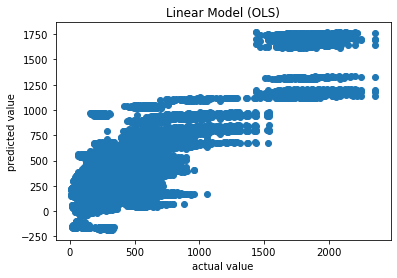

the rmse for an OLS Regression here is 223.62338407187764


In [42]:
lin_pred = lin_model.predict(X_train)

# plot the residuals on a scatter plot
plt.scatter(y_train, lin_pred)
plt.title('Linear Model (OLS)')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

print('the rmse for an OLS Regression here is', rmse(lin_pred, y_train))

3.3.2) Ridge regression

In [43]:
ridge_reg = Ridge() 
ridge_model = ridge_reg.fit(X_train, y_train)

Text(0.5, 1.0, 'Ridge Model')

Text(0.5, 0, 'actual values')

Text(0, 0.5, 'predicted values')

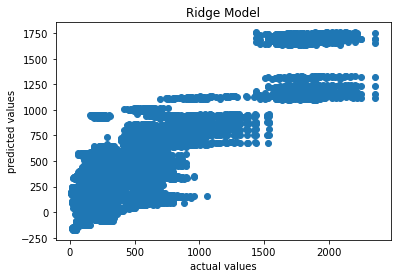

the rmse for a Ridge Regression here is 223.79996734836988


In [44]:
# use the model to make predictions
ridge_pred = ridge_model.predict(X_train)

# plot the predictions
plt.scatter(y_train, ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

print('the rmse for a Ridge Regression here is', rmse(ridge_pred, y_train))

3.3.3) Lasso regression

In [45]:
# create and fit the model
lasso_reg = Lasso(max_iter=10000)  
lasso_model = lasso_reg.fit(X_train, y_train)

Text(0.5, 1.0, 'LASSO Model')

Text(0.5, 0, 'actual values')

Text(0, 0.5, 'predicted values')

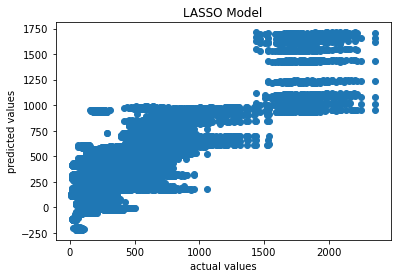

the rmse for a Lasso Regression here is 240.03905312628243


In [46]:
# use the model to make predictions
lasso_pred = lasso_model.predict(X_train)

# plot the predictions
plt.scatter(y_train, lasso_pred)
plt.title('LASSO Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

print('the rmse for a Lasso Regression here is', rmse(lasso_pred, y_train))

3.3.4) How well does each model fit the training data?

In [47]:
k = len(X_train.columns)
n = len(X_train.index)

In [48]:
lin_reg_hat = lin_model.predict(X_train)
lin_reg_resid = y_train - lin_reg_hat
lin_reg_sse = sum(lin_reg_resid**2)

lin_AIC = 2*k - 2*np.log(lin_reg_sse)
lin_BIC = n*np.log(lin_reg_sse/n) + k*np.log(n)

In [49]:
ridge_reg_hat = ridge_model.predict(X_train)
ridge_reg_resid = y_train - ridge_reg_hat
ridge_reg_sse = sum(ridge_reg_resid**2)

ridge_AIC = 2*k - 2*np.log(ridge_reg_sse)
ridge_BIC = n*np.log(ridge_reg_sse/n) + k*np.log(n)

In [50]:
lasso_reg_hat = lasso_model.predict(X_train)
lasso_reg_resid = y_train - lasso_reg_hat
lasso_reg_sse = sum(lasso_reg_resid**2)

lasso_AIC = 2*k - 2*np.log(lasso_reg_sse)
lasso_BIC = n*np.log(lasso_reg_sse/n) + k*np.log(n)

In [51]:
min(lin_AIC, ridge_AIC, lasso_AIC)
min(lin_BIC, ridge_BIC, lasso_BIC)

# lin_AIC
# ridge_AIC
# lasso_AIC

# print('\n')

# lin_BIC
# ridge_BIC
# lasso_BIC

270.15545154201754

230687.45094558928

In [52]:
print('Lasso Regression has the lowest AIC score of 270.1829533496053.\nLinear regression has the lowest BIC score of 3239.0400977215313.')


Lasso Regression has the lowest AIC score of 270.1829533496053.
Linear regression has the lowest BIC score of 3239.0400977215313.


While Linear Regression has the lowest BIC score, I'm also going to test Lasso Regression for it's lowest AIC score. I've already got the feeling that a linear regression isn't quite appropriate for data with so many features, and when I've run cross-validations later in this work I've found that a Lasso Regression is much more accomodating. That, combined with it's appropriate BIC, is why I'm also choosing Lasso Regression. 

3.4) Tune your model using the training and validation sets. Then choose your best model and run it on the test set.

In [53]:
# make predictions for each model
lin_vpred = lin_model.predict(X_validate)
ridge_vpred = ridge_model.predict(X_validate)
lasso_vpred = lasso_model.predict(X_validate)

lin_testpred = lin_model.predict(X_test)
ridge_testpred = ridge_model.predict(X_test)
lasso_testpred = lasso_model.predict(X_test)

In [54]:
# calculate RMSE for each set of validation predictions
print("linear model rmse: ", rmse(lin_vpred, y_validate))
print("Ridge rmse: ", rmse(ridge_vpred, y_validate))
print("LASSO rmse: ", rmse(lasso_vpred, y_validate))

rmse_data = {"Regression Models": ['OLS','Ridge','Lasso'],
             "Training Predicted RMSEs": [rmse(lin_pred, y_train),rmse(ridge_pred, y_train),rmse(lasso_pred, y_train)],
             "Validation Predicted RMSEs": [rmse(lin_vpred, y_validate),rmse(ridge_vpred, y_validate),rmse(lasso_vpred, y_validate)],
             "Test Predicted RMSEs": [rmse(lin_testpred, y_validate),rmse(ridge_testpred, y_validate),rmse(lasso_testpred, y_validate)]}
compare_rmse = pd.DataFrame(data=rmse_data)
compare_rmse

linear model rmse:  217.9740422972222
Ridge rmse:  218.34148018167542
LASSO rmse:  233.72360460302176


,Regression Models,Training Predicted RMSEs,Validation Predicted RMSEs,Test Predicted RMSEs
0,OLS,223.623384,217.974042,523.000284
1,Ridge,223.799967,218.341480,520.606365
2,Lasso,240.039053,233.723605,500.966517


In [55]:
# make predictions for the test set using one model of your choice
final_pred = lin_model.predict(X_test)
# calculate the rmse for the final predictions
print('Final test set rmse: ', rmse(final_pred, y_test))

Final test set rmse:  221.78350917301887


In [56]:
# make predictions for the test set using one model of your choice
final_pred = lin_model.predict(X_test)
# calculate the rmse for the final predictions
print('Final test set rmse: ', rmse(final_pred, y_test))

Final test set rmse:  221.78350917301887


Text(0.5, 1.0, 'Final Linear Model (OLS)')

Text(0.5, 0, 'actual value')

Text(0, 0.5, 'predicted value')

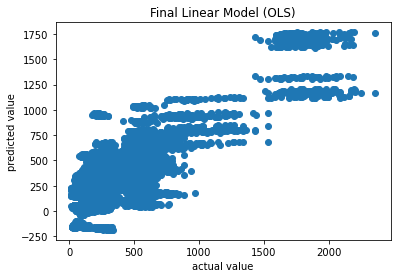

In [57]:
plt.scatter(y_test, final_pred)
plt.title('Final Linear Model (OLS)')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

(a) Which model(s) has the best performance on the validation set? In addition to the metrics you choose, also report the correlation (Pearson or r2) between your predicted values and the observed values.

OLS still has the best performance on the validation set, unfortunately. But not by much - Ridge regression places as a close second.

(b) Why is it good practice to do a train/validation/test split, instead of just a train/test split?

Validation data allows us to get an idea of how accurate the model will be without actually exposing it to our test set. We want to optimize the hyperparameters of our model as much as possible before using the test set. If we repeatedly test our model just against test data only, it will become overfitted.

(c) Why is it considered unethical, in an industry or academic publication, to run your model on the test set multiple times (changing something about your model in between)?

(d) In general, should predictions in the validation and test sets be more or less accurate than predictions on the training set? Why?

In general, the prediction RMSEs from the training sets will be lower than the prediction RMSEs from the test sets. The training models are more fit to the data, and as a result should have less variance. The test sets are not trained on, and will have more opportunities for different scenarios, and eventual variance in scores. 

3.5) Also train your best model using cross-validation.

Text(0.5, 1.0, 'Linear Regression')

Text(0.5, 0, 'actual value')

Text(0, 0.5, 'predicted value')

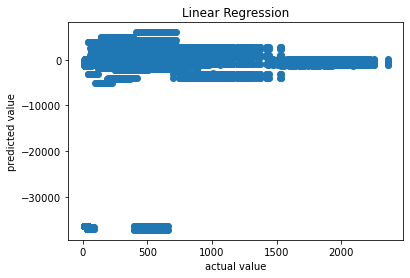

In [60]:
lin_cross_predicted = cross_val_predict(lin_reg, X, y, cv = 3)
# r2_score(y, lin_cross_predicted)

# plot the residuals on a scatter plot
plt.scatter(y, lin_cross_predicted)
plt.title('Linear Regression')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

# print('The cross validation score for a lasso regression here is',cross_val_score(lasso_reg, X, y, cv=3, scoring='r2').mean())
# print('Final cross-validated set rmse: ', rmse(lin_cross_predicted, y_test))

# 4 Generalize to a new dataset

4.1) Now let’s test the model on a brand new dataset. Download the cleaned NYPD data from bcourses, and predict neighborhood crime rates in New York City. Choose your best/preferred model. How accurate is it?

In [61]:
# the reasoning behind the 'r' used to create a raw string can be found here: https://stackoverflow.com/questions/1347791/unicode-error-unicodeescape-codec-cant-decode-bytes-cannot-open-text-file
df = pd.read_csv(r'C:\\Users\\kharr\\Documents\\GitHub\\Problem-Set-2-Legal-Studies-123\Data\NY Crime By Neighborhood.csv')
# df = pd.read_csv('C:\\Users\\kharr\\Documents\\GitHub\\Problem-Set-2-Legal-Studies-123\Data\San Francisco Crime by Neighborhood and Tract.csv')

In [62]:
df.head()
print('df has',df.index.size,'rows')
# df.columns.values

,Month_Year,number_crimes,tract_no,neighborhood,VC03,VC04,VC05,VC06,VC07,VC08,...,VC206,VC207,VC208,VC209,VC210,VC211,VC212,VC216,VC217,VC218
0,01/1999,1,100,Rikers Island,0,0,0,0,0,0,...,0,63,0,0,5,0,283,NaN,NaN,NaN
1,01/2002,1,100,Rikers Island,0,0,0,0,0,0,...,0,63,0,0,5,0,283,NaN,NaN,NaN
2,01/2003,2,100,Rikers Island,0,0,0,0,0,0,...,0,63,0,0,5,0,283,NaN,NaN,NaN
3,01/2005,3,100,Rikers Island,0,0,0,0,0,0,...,0,63,0,0,5,0,283,NaN,NaN,NaN
4,01/2006,155,100,Rikers Island,0,0,0,0,0,0,...,0,63,0,0,5,0,283,NaN,NaN,NaN


df has 375423 rows


In [63]:
df = df.drop_duplicates()
df = df.fillna(0)
df.index.size

368253

In [64]:
df.isnull().values.any()

False

In [65]:
df["Month_Year"] = pd.to_datetime(df["Month_Year"], infer_datetime_format=True, errors = 'coerce')
df.head()

,Month_Year,number_crimes,tract_no,neighborhood,VC03,VC04,VC05,VC06,VC07,VC08,...,VC206,VC207,VC208,VC209,VC210,VC211,VC212,VC216,VC217,VC218
0,1999-01-01,1,100,Rikers Island,0,0,0,0,0,0,...,0,63,0,0,5,0,283,0.0,0.0,0.0
1,2002-01-01,1,100,Rikers Island,0,0,0,0,0,0,...,0,63,0,0,5,0,283,0.0,0.0,0.0
2,2003-01-01,2,100,Rikers Island,0,0,0,0,0,0,...,0,63,0,0,5,0,283,0.0,0.0,0.0
3,2005-01-01,3,100,Rikers Island,0,0,0,0,0,0,...,0,63,0,0,5,0,283,0.0,0.0,0.0
4,2006-01-01,155,100,Rikers Island,0,0,0,0,0,0,...,0,63,0,0,5,0,283,0.0,0.0,0.0


In [66]:
df['yyyy'] = (pd.to_datetime(df['Month_Year']).dt.year)
df['mm'] = pd.to_datetime(df['Month_Year']).dt.month

move_yyyy = df.pop("yyyy")
df.insert(2, "yyyy", move_1 )

move_mm = df.pop("mm")
df.insert(3, "mm", move_2 )

move_neighborhood = df.pop("neighborhood")
df.insert(0, "neighborhood", move_neighborhood )

move_crimes = df.pop("number_crimes")
df.insert(4, "number_crimes", move_crimes )

df.head()

,neighborhood,Month_Year,yyyy,mm,number_crimes,tract_no,VC03,VC04,VC05,VC06,...,VC206,VC207,VC208,VC209,VC210,VC211,VC212,VC216,VC217,VC218
0,Rikers Island,1999-01-01,2003.0,1.0,1,100,0,0,0,0,...,0,63,0,0,5,0,283,0.0,0.0,0.0
1,Rikers Island,2002-01-01,2004.0,1.0,1,100,0,0,0,0,...,0,63,0,0,5,0,283,0.0,0.0,0.0
2,Rikers Island,2003-01-01,2005.0,1.0,2,100,0,0,0,0,...,0,63,0,0,5,0,283,0.0,0.0,0.0
3,Rikers Island,2005-01-01,2006.0,1.0,3,100,0,0,0,0,...,0,63,0,0,5,0,283,0.0,0.0,0.0
4,Rikers Island,2006-01-01,2007.0,1.0,155,100,0,0,0,0,...,0,63,0,0,5,0,283,0.0,0.0,0.0


In [67]:
df = df.fillna(0)

In [68]:
df['neighborhood'] = pd.factorize(df.neighborhood)[0] + 1
X = df

X = X.drop(['number_crimes'], axis=1)
X = X.drop(['Month_Year'], axis=1) #now that we have month and year as their own columns, this is okay. 

y = df['number_crimes']

In [69]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)
X.head(2)

y = df['number_crimes']

,neighborhood,yyyy,mm,tract_no,VC03,VC04,VC05,VC06,VC07,VC08,...,VC206,VC207,VC208,VC209,VC210,VC211,VC212,VC216,VC217,VC218
0,-1.342556,3.119235,0.186308,-1.083549,-1.62004,-1.732328,-1.589753,-1.542002,-1.472718,-1.198355,...,-0.265983,-0.263066,-0.329096,-0.273899,-0.284605,-0.305421,-0.044095,0.0,0.0,0.0
1,-1.342556,3.120951,0.186308,-1.083549,-1.62004,-1.732328,-1.589753,-1.542002,-1.472718,-1.198355,...,-0.265983,-0.263066,-0.329096,-0.273899,-0.284605,-0.305421,-0.044095,0.0,0.0,0.0


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20)


X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                    train_size=0.75, test_size=0.25)

In [71]:
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

Text(0.5, 1.0, 'Linear Model (OLS)')

Text(0.5, 0, 'actual value')

Text(0, 0.5, 'predicted value')

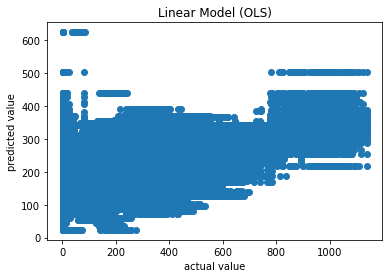

the rmse for an OLS Regression here is 196.2908098276764


In [72]:
lin_reg = LinearRegression()
lin_model = lin_reg.fit(X_train, y_train)

lin_pred = lin_model.predict(X_train)

# plot the residuals on a scatter plot
plt.scatter(y_train, lin_pred)
plt.title('Linear Model (OLS)')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

print('the rmse for an OLS Regression here is', rmse(lin_pred, y_train))

4.2) In general, what are the potential challenges with extrapolating from data trained on a San Francisco dataset to a New York City dataset?

There are a few potential challenges, the first being that the shared features of each dataset can vary widely. For example, the population density (not to mention population size) in NYC is very different from that in SF.I would also imagine that as a result, total household per tract and all extended features would also be very different. Education by neighborhood would be very difficult to translate given that NYC and SF are structured differently, and arguably anything regarding ethnicity or language spoken would also be difficult given just how diverse NYC is. 

Additionally, a model that's been tuned based on specific SF data is going to be difficult to extrapolate to any city, not just San Francisco. While it hasn't necessarily been overfitted, it has been trained, and for completely new data like a different city, it will need new training and new parameters to stay accurate. 

# Bias and Fairness in Machine Learning

5.1) Install the “Aequitas” package. Instructions are here (https://github.com/dssg/aequitas) and info about Aequitas can be found here (http://aequitas.dssg.io/).

Aequitas was developed by the Center for Data Science and Public Policy at the University of Chicago. It is a “bias and fairness audit toolkit” that aims to help policymakers understand the
ethical implications of their algorithmic decisions.

In [73]:
pip install aequitas

  Created wheel for Flask-Bootstrap: filename=Flask_Bootstrap-3.3.7.1-py3-none-any.whl size=460123 sha256=49d62bf0e27be57d69f7b7eea1069b9cdbbbd5d13076e06f8542dc0582ba4edd
  Stored in directory: c:\users\kharr\appdata\local\pip\cache\wheels\bb\41\c0\e09286bce2bca8d80bcaeccf519aa73b9747278e78ca83ce3f
  Created wheel for markdown2: filename=markdown2-2.3.5-py3-none-any.whl size=62845 sha256=08c00bd06a1359196244a1f335687c6c26d36cd32a65351c48eb24b5feff9601
  Stored in directory: c:\users\kharr\appdata\local\pip\cache\wheels\2e\ea\b4\0217163e1c62e252842e509a0c23f218c55981f62191b87d95
  Created wheel for millify: filename=millify-0.1.1-py3-none-any.whl size=1866 sha256=b95dcd60303dd35cf790bbd31ba9d958609283124705a7ef38d63c025f63357a
  Stored in directory: c:\users\kharr\appdata\local\pip\cache\wheels\4d\a6\58\ab31aca0c3bb6be6ae878845aed85d55c3d580b6d0b2e71486
  Created wheel for tabulate: filename=tabulate-0.8.2-py3-none-any.whl size=23550 sha256=3b31597894834bdf840f6f4d0ab1df6774acf549a03835

5.2) Run the Aequitas program on your models.

5.2.a) Choose initial audit goals for you bias report, and discuss your justification for these goals. For example, explain why you might choose “False Negative Rate Parity” over “False Positive
Rate Parity” or vice versa depending on the context.

5.2.b) Does your model pass your audit goals? If so, discuss whether you would be comfortable proceeding using it in a real world application. If not, discuss what the potential problems are that contribute to the failure, and whether you think you can overcome these to make a ethically and legally fair algorithm.

# Discussion Questions

6.1) Define bias-variance tradeoff. Why is it relevant to prediction in machine learning?

As we further tune our model to the dataset, it can become focused on certain relationships and completely miss others. This is one source of model error known as bias. However if we go in the other direction and allow the model to attempt to capture all relationships between all features, our model will become very sensitive to changes in new data (overfitted to old data) and will not make accurate predictions either. This is the variance issue. While sepearate sources of error, most often reducing one results in an increase in the other, and vice versa.

It's relevance to prediction ties back to the questions answered earlier about overfitting to training data, and is why we have validation and testing data as well. Proper predictive models necessitate the correct balance between these two sources of error, or else they will not be able to accomodate new data. And in reality, the world is full of new, unpredictable, and rich data that will not be easily interpreted unless we have models that have been created properly. 

6.2) Define overfitting. Why does this phenomenon tend to arise in the machine learning process, and what can be done to correct for it?

Overfitting is when a model has been to specifically trained to the training dataset, and performs poorly when run on the test dataset. This happens when we allow high variance, and the model attempts to cature all relationships between features. But either because of different features, different external characteristics of the data sources, or the tuning of the model, the initial model can be too tailored to the test data and fail to accurately predict results when given new data. 

6.3) What are the advantages and disadvantages of using a predictive algorithm to predict neighborhood crime?

One major disadvantage that's talked about quite often in data ethics spaces is the "black box" issue where citizens affected by increased police presence don't get to know why decisions were made, or particularly how. And while technically some cities publicly offer the stops/crime/calls data that's used to make these predictions, they still aren't really given notice of when, how, or why private contractors come in and build these programs. Even in cities where these operations are done internally, citizens often don't have a choice in how they're conducted or if they can be stopped. 

An advantage is that, like our previous project, properly trained predictive algorithms can give police departments an idea of where to focus their efforts, and how to understand vast amounts of data. Hotspot policing has been found to have some (while small) benefits, and properly allocated police presence is certainly better than subjectively or randomly allocated presence. 